In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data Readout

In [2]:
import re

def Grid_from_header(header):
    '''Generate coordinates grid from the header data of an fld file'''

    # Extract basic data from header
    min_match = re.search(r'Min: \[([^\]]+)\]', header)
    max_match = re.search(r'Max: \[([^\]]+)\]', header)
    size_match = re.search(r'Grid Size: \[([^\]]+)\]', header)
    if min_match and max_match and size_match:
        min_vals = [float(val.replace('mm', 'e-3')) for val in min_match.group(1).split()]
        max_vals = [float(val.replace('mm', 'e-3')) for val in max_match.group(1).split()]
        grid_size_vals = [float(val.replace('mm', 'e-3')) for val in size_match.group(1).split()]
    else:
        raise ValueError('Unable to analyze the header')
    x_min, y_min, z_min = min_vals
    x_max, y_max, z_max = max_vals
    dx, dy, dz = grid_size_vals

    # Generate the grid
    X = np.arange(x_min, x_max + dx/2, dx)
    Y = np.arange(y_min, y_max + dy/2, dy)
    Z = np.arange(z_min, z_max + dz/2, dz)
    xs, ys, zs = np.meshgrid(X, Y, Z, indexing='ij')
    nx = len(X)
    ny = len(Y)
    nz = len(Z)

    return xs, ys, zs, nx, ny, nz

In [3]:
def Vec_from_file(filename):
    '''Read vector data (DC E field) from an Ansys fld file and return result in grid shaped array'''

    # Open file and read content
    f = open(filename)
    lines = f.readlines()
    f.close()

    # Generate grid array from header
    header = lines[0]
    xs, ys, zs, nx, ny, nz = Grid_from_header(header)

    # Read file data
    Ex = np.zeros(len(lines)-2)
    Ey = np.zeros(len(lines)-2)
    Ez = np.zeros(len(lines)-2)
    for i, line in enumerate(lines[2:]):
        try:
            E = line.split(' ')[-3:]
            Ex[i] = float(E[0])
            Ey[i] = float(E[1])
            Ez[i] = float(E[2])
        except:
            print('Error:', i, line.split(' ')[-3:])

    # Reshape the data 
    E = {}
    E['x'] = Ex.reshape((nx, ny, nz))
    E['y'] = Ey.reshape((nx, ny, nz))
    E['z'] = Ez.reshape((nx, ny, nz))

    return xs, ys, zs, E

In [4]:
def Scalar_from_file(filename):
    '''Read scalar data (DC potential, RF MagE) from an Ansys fld file and return result in grid shaped array'''
    
    # Open file and read content
    with open(filename) as f:
        lines = f.readlines()

    # Generate grid array from header
    header = lines[0]
    xs, ys, zs, nx, ny, nz = Grid_from_header(header)
    
    # Read file data
    data = np.zeros(len(lines)-2)
    for i, line in enumerate(lines[2:]):
        try:
            data[i] = float(line.split(' ')[-1])
        except:
            print('Error:', i, line.split(' ')[-1])

    # Reshape the data
    data_grid = data.reshape((nx, ny, nz))

    return xs, ys, zs, data_grid

In [5]:
# Data Readout
prefix = '..\\Ansys\\'
DC_file = 'Outputs_DC\\Mesh_MCP_Global\\Mesh.fld'
RF_file = 'Outputs_RF\\TrajSimTest.fld'

xdc, ydc, zdc, Udc = Scalar_from_file(prefix + DC_file)
xrf, yrf, zrf, magE = Scalar_from_file(prefix + RF_file)

# Calculate Equivalent Forces
1. Calculate RF pseudopotential from magE.
2. Calculate equivalent E fields by taking their gradient, then we can calculate forces easily.

Additional Information: $U_{ps}$ is NaN inside the RF electrode, this will cause some NaN in RF force field. Correct way to deal with this is to terminate trajectory simulation when the electron bumps into any NaN

In [6]:
# Basic Trapping Paramenters
m = 9.1093837e-31
q = -1.60217663e-19
freq = 1.36e+09
stepsize = 1e-4

# Calculate pseudopotential in J (not eV)
Ups = (q*magE) ** 2 / (4 * m * (2*np.pi*freq) ** 2)

In [7]:
# RF equivalent electric field
F_rf = np.gradient(Ups, stepsize)
Ex_rf = -F_rf[0] / q
Ey_rf = -F_rf[1] / q
Ez_rf = -F_rf[2] / q

In [8]:
# DC electric field
E_dc = np.gradient(Udc, stepsize)
Ex_dc = -E_dc[0]
Ey_dc = -E_dc[1]
Ez_dc = -E_dc[2]

In [9]:
# Delete Unneeded Parameters to Release Memory
#import gc

#del Udc, magE, Ups, F_rf, F_dc
#gc.collect()

# Create Interpolation for Forces

In [10]:
from scipy.interpolate import griddata

def fill_NaN_nearest(data, X, Y, Z):
    '''Fill NaN in a data set by its nearest value.'''

    # Get all valid points and values
    valid_mask = ~np.isnan(data)
    valid_points = np.column_stack((X[valid_mask], Y[valid_mask], Z[valid_mask]))
    valid_values = data[valid_mask]

    # Get all points
    all_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # Fill data with nearest method and reshape back to the same shape as data
    filled_data = griddata(valid_points, valid_values, all_points, method='nearest').reshape(data.shape)

    return filled_data

In [11]:
# Create grid point arrays aceepted by the interpolator
xrf_unique = np.unique(xrf)
yrf_unique = np.unique(yrf)
zrf_unique = np.unique(zrf)
xdc_unique = np.unique(xdc)
ydc_unique = np.unique(ydc)
zdc_unique = np.unique(zdc)

In [12]:
from scipy.interpolate import RegularGridInterpolator
import time

Ex_rf_filled = fill_NaN_nearest(Ex_rf, xrf, yrf, zrf)
Exrf_interp_func = RegularGridInterpolator((xrf_unique, yrf_unique, zrf_unique), Ex_rf_filled, method='linear')

Linear interpolation computation time: 0.0060 seconds
Linear interpolation computation time: 0.0000 seconds
Number of NaNs: 0
Maximum Error: 	116.59552404364872
Average Error: 	0.37553148912498185
SD of Error: 	2.9356198527346695


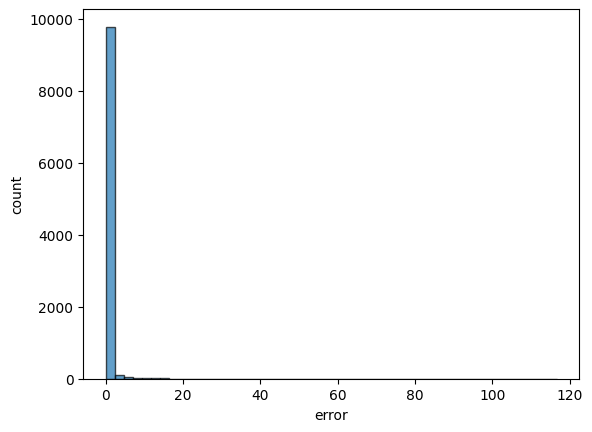

In [13]:
test_interp_func = RegularGridInterpolator((xrf_unique, yrf_unique, zrf_unique), Ex_rf_filled, method='nearest')

num_points = 10000
x_rand = np.random.uniform(-0.008, 0.008, num_points)
y_rand = np.random.uniform(-0.0065, 0.0065, num_points)
z_rand = np.random.uniform(-0.001, 0.01, num_points)
points = np.column_stack((x_rand, y_rand, z_rand))

start_time = time.time()
linear_values = Exrf_interp_func(points)
end_time = time.time()
print(f'Linear interpolation computation time: {end_time - start_time:.4f} seconds')

start_time = time.time()
nearest_values = test_interp_func(points)
end_time = time.time()
print(f'Linear interpolation computation time: {end_time - start_time:.4f} seconds')

errors = np.abs(linear_values - nearest_values) / abs(nearest_values)
print(f'Number of NaNs: {sum(np.isnan(errors))}')
valid_errors = errors[~np.isnan(errors)]

max_error = np.max(valid_errors)
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)
print(f'Maximum Error: \t{max_error}')
print(f'Average Error: \t{mean_error}')
print(f'SD of Error: \t{std_error}')

plt.hist(valid_errors, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('error')
plt.ylabel('count')
plt.show()

In [37]:
threshold = 100
err_points = []
for i in range(len(linear_values)):
    if abs(linear_values[i] - nearest_values[i]) > threshold * abs(nearest_values[i]): 
        #print(f'点 {i}: 坐标 {points[i]}, 线性插值 {linear_values[i]}, 最近邻插值 {nearest_values[i]}')
        err_points.append(i)

print('\n')

for p in err_points:
    print(f'Point {p}: Coordinate {points[p]}, Relative Error {relative_errors[p]}, Linear Interpolation {linear_values[p]}, Nearest Value {nearest_values[p]}')
    #print('\n')



Point 727: Coordinate [-0.00332904  0.00131303 -0.00043387], Relative Error 244.35910840659798, Linear Interpolation 16.45802105328488, Nearest Value -0.0676285394084665
Point 783: Coordinate [ 0.00774507 -0.00634778  0.00042643], Relative Error 153.28476012238647, Linear Interpolation 0.8215796306044493, Nearest Value -0.005395021996581742
Point 2093: Coordinate [0.00482367 0.0004779  0.00043046], Relative Error 142.39158376893215, Linear Interpolation -5.379723195303319, Nearest Value -0.03751770539038368
Point 4875: Coordinate [-0.00547885 -0.00196278  0.00044401], Relative Error 142.98339987809663, Linear Interpolation 13.316301698580816, Nearest Value 0.09248497889239347
Point 5879: Coordinate [ 0.0066759  -0.00370252  0.00374009], Relative Error 271.8502719902336, Linear Interpolation -1.4043629717325787, Nearest Value -0.005147009608928836
Point 5927: Coordinate [ 4.99247017e-03 -4.97099219e-05  1.53898290e-04], Relative Error 119.84431597177175, Linear Interpolation -0.666132

[[-7.27445442e-04  4.37989016e-03  2.71874870e-03]
 [ 1.21887293e-03  2.42667729e-03  6.41532235e-03]
 [-6.30425498e-03  4.62359954e-03  9.77901656e-03]
 ...
 [-3.26185963e-03 -4.86732091e-05  4.26883328e-03]
 [-6.92232345e-03 -1.20653528e-03  1.45937120e-03]
 [ 4.09236653e-03  4.52154076e-03  8.19708664e-03]]
Linear interpolation computation time: 0.0400 seconds
Nearest neighbor interpolation computation time: 0.0400 seconds
[False False False ... False False False]
相对误差大于 10 的点数：54


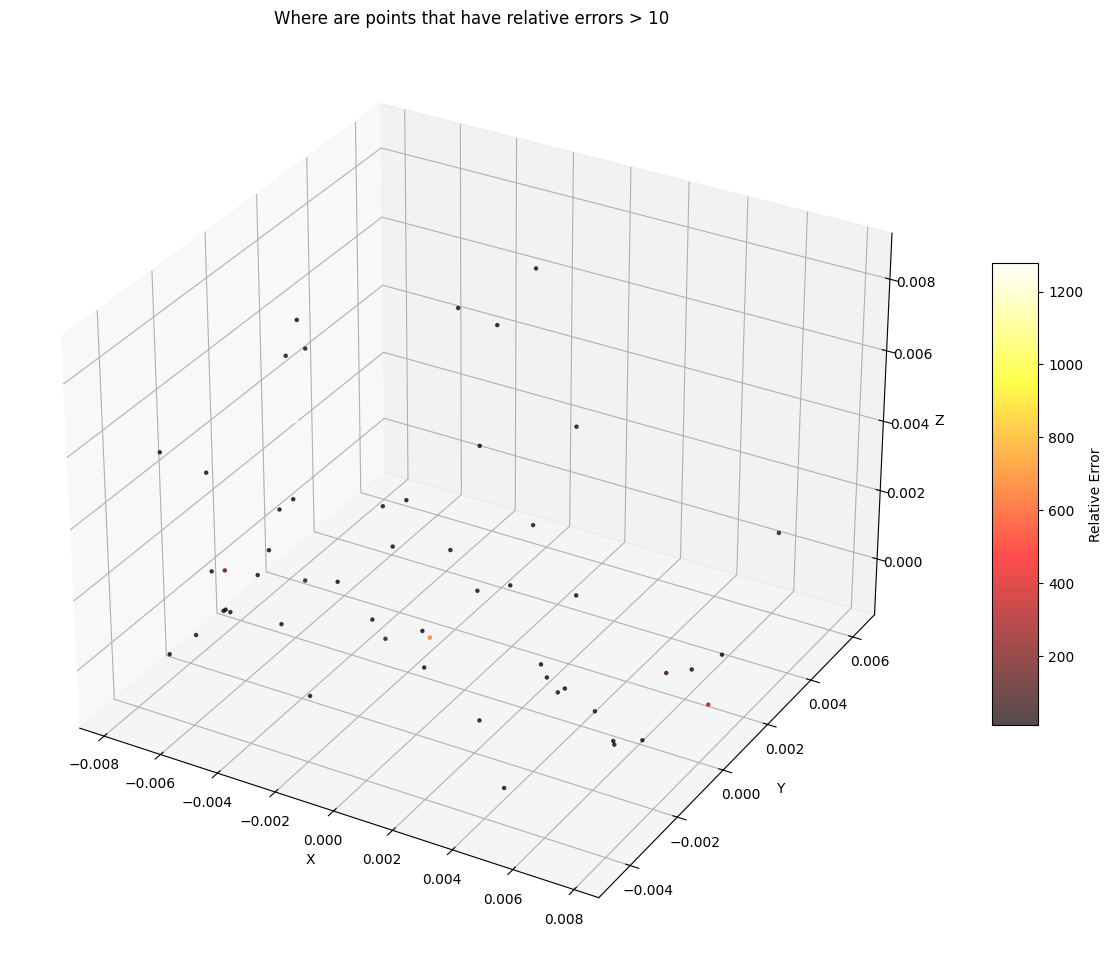

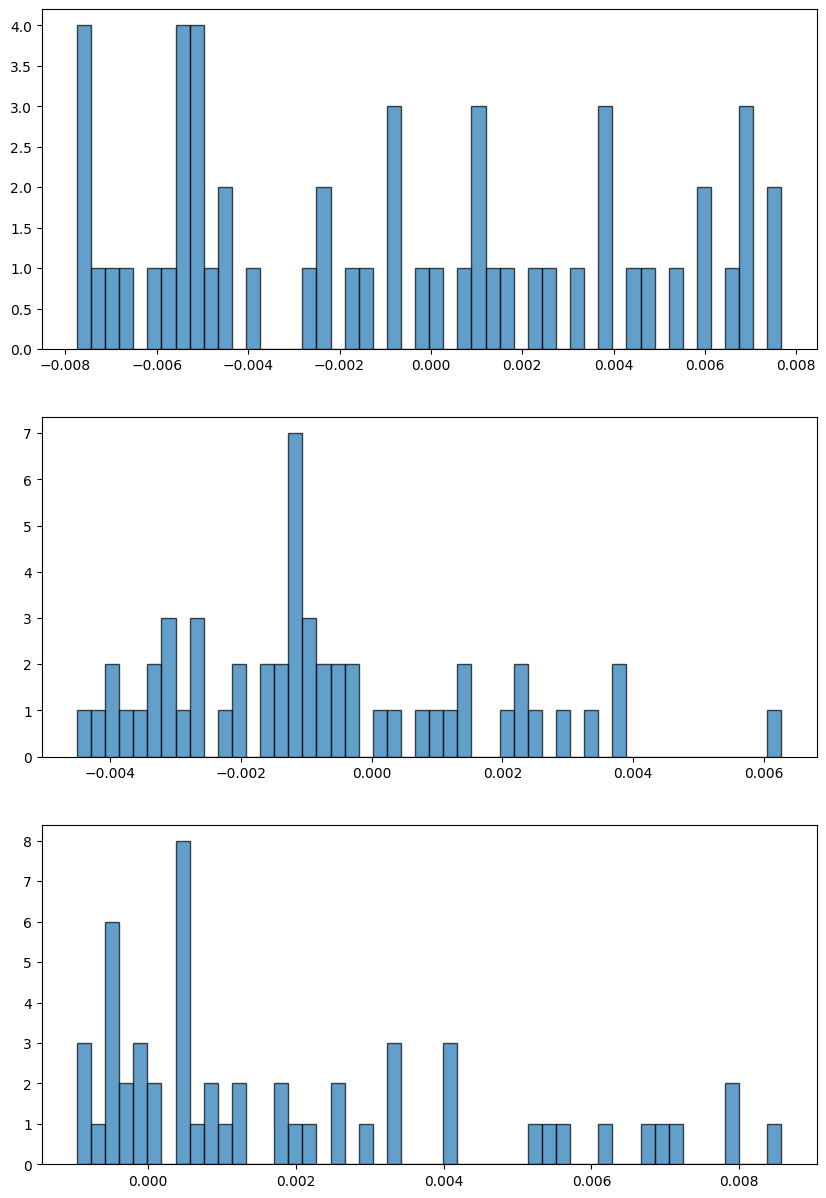

In [44]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 绘图工具

# 假设您已经正确创建了插值函数 Fxrf_interp_func 和 test_interp_func

#'''
# 生成随机测试点
num_points = 10000
x_rand = np.random.uniform(-0.008, 0.008, num_points)
y_rand = np.random.uniform(-0.0065, 0.0065, num_points)
z_rand = np.random.uniform(-0.001, 0.01, num_points)
points = np.column_stack((x_rand, y_rand, z_rand))
#'''

'''
# Create grid positions
x_vals = np.linspace(-0.0079, 0.0079, 500)
y_vals = np.linspace(-0.0064, 0.0064, 300)
z_vals = np.linspace(-0.0009, 0.0099, 300)
x_grid, y_grid, z_grid = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
points = np.column_stack((x_grid.ravel(), y_grid.ravel(), z_grid.ravel()))
'''

print(points)

# 执行插值计算
start_time = time.time()
linear_values = Exrf_interp_func(points)
end_time = time.time()
print(f'Linear interpolation computation time: {end_time - start_time:.4f} seconds')

start_time = time.time()
nearest_values = test_interp_func(points)
end_time = time.time()
print(f'Nearest neighbor interpolation computation time: {end_time - start_time:.4f} seconds')

# 处理插值结果中的 nan
#valid_mask = (~np.isnan(linear_values)) & (~np.isnan(nearest_values))
#linear_values_valid = linear_values[valid_mask]
#nearest_values_valid = nearest_values[valid_mask]
#points_valid = points[valid_mask]

# 计算修正后的相对误差
#relative_errors = np.abs(linear_values_valid - nearest_values_valid) / np.abs(nearest_values_valid)
relative_errors = np.abs(linear_values - nearest_values) / np.abs(nearest_values)

# 设置相对误差阈值
threshold = 10  # 例如 0.1 表示 10%
error_mask = relative_errors > threshold
print(error_mask)
large_error_points = points[error_mask] #points_valid[error_mask]
large_error_values = relative_errors[error_mask]

print(f'相对误差大于 {threshold} 的点数：{len(large_error_points)}')

# 打印这些点的坐标和对应的相对误差
#for i in range(len(large_error_points)):
    #print(f'点 {i}: 坐标 {large_error_points[i]}, 相对误差 {large_error_values[i]}, 线性插值 {linear_values_valid[i]}, 最近邻插值 {nearest_values_valid[i]}')
    #print(f'点 {i}: 坐标 {large_error_points[i]}, 相对误差 {large_error_values[i]}, 线性插值 {linear_values[i]}, 最近邻插值 {nearest_values[i]}')

# **绘制三维散点图**

# 创建一个三维图形对象
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用相对误差作为颜色映射
scatter = ax.scatter(
    large_error_points[:, 0],  # X 坐标
    large_error_points[:, 1],  # Y 坐标
    large_error_points[:, 2],  # Z 坐标
    c=large_error_values,      # 点的颜色映射到相对误差值
    cmap='hot',                # 颜色映射表，可以根据喜好选择
    marker='.',                # 标记样式
    alpha=0.7                  # 透明度
)

# 添加颜色条
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Relative Error')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图形标题
ax.set_title(f'Where are points that have relative errors > {threshold}')

fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
ax1.hist(large_error_points[:, 0], bins=50, edgecolor='k', alpha=0.7)
ax2.hist(large_error_points[:, 1], bins=50, edgecolor='k', alpha=0.7)
ax3.hist(large_error_points[:, 2], bins=50, edgecolor='k', alpha=0.7)

# 显示图形
plt.show()

import gc
delete = False
if delete:
    del x_rand, y_rand, z_rand, points, linear_values, nearest_values, relative_errors
    gc.collect()

In [109]:
import numpy as np
import warnings

def find_adjacent_points(point, offset=5e-5, x_range=None, y_range=None, z_range=None):
    """
    Finds the 6 adjacent sample points with specified offsets to a given sample point.
    If grid boundaries are provided, ensures that the adjacent points are within the grid boundaries.
    If grid boundaries are not provided, a warning is issued and boundary checks are skipped.
    
    Parameters:
        point (array-like): The coordinate [x, y, z] of the point of interest.
        offset (float or list/tuple of floats, optional): The offset distance(s) to adjacent points.
            - If a single float is provided, the same offset is used in all directions.
            - If a list or tuple of three floats is provided, they specify the offsets
              in the x, y, and z directions, respectively.
            Defaults to 5e-5.
        x_range (tuple, optional): The (min, max) values of the x-axis grid.
        y_range (tuple, optional): The (min, max) values of the y-axis grid.
        z_range (tuple, optional): The (min, max) values of the z-axis grid.
            If any of these are not provided and the corresponding global variables
            'xrange', 'yrange', 'zrange' do not exist, boundary checks are skipped.

    Returns:
        list: A list of coordinates of the adjacent points. If grid boundaries are provided,
              only points within the boundaries are included.

    Raises:
        ValueError: If any of the adjacent points fall outside the grid boundaries (when boundaries are provided).
        ValueError: If 'offset' is not a single float or a list/tuple of three floats.
    """
    # Ensure that offset is in the correct format
    if isinstance(offset, (int, float)):
        # Single value provided; use the same offset in all directions
        offset_x = offset_y = offset_z = offset
    elif isinstance(offset, (list, tuple, np.ndarray)) and len(offset) == 3:
        # Individual offsets provided for each axis
        offset_x, offset_y, offset_z = offset
    else:
        raise ValueError("Offset must be a single float or a list/tuple of three floats.")

    # Unpack the coordinates of the given point
    x, y, z = point

    # Define the six possible directions with their respective offsets
    directions = [
        np.array([offset_x, 0, 0]),    # Positive x-direction
        np.array([-offset_x, 0, 0]),   # Negative x-direction
        np.array([0, offset_y, 0]),    # Positive y-direction
        np.array([0, -offset_y, 0]),   # Negative y-direction
        np.array([0, 0, offset_z]),    # Positive z-direction
        np.array([0, 0, -offset_z])    # Negative z-direction
    ]

    # Check if grid boundaries are provided or can be obtained
    boundaries_provided = True
    if x_range is None or y_range is None or z_range is None:
        # Try to get global variables if they exist
        try:
            x_range = x_range if x_range is not None else xrange
        except NameError:
            x_range = None
        try:
            y_range = y_range if y_range is not None else yrange
        except NameError:
            y_range = None
        try:
            z_range = z_range if z_range is not None else zrange
        except NameError:
            z_range = None

        # If any range is still None, skip boundary checks
        if x_range is None or y_range is None or z_range is None:
            boundaries_provided = False
            warnings.warn("Grid boundaries are not provided. Boundary checks will be skipped.")

    adjacent_points = []
    for direction in directions:
        adj_point = point + direction
        # Check if the adjacent point is within the grid boundaries if boundaries are provided
        if boundaries_provided:
            if (x_range[0] <= adj_point[0] <= x_range[1] and
                y_range[0] <= adj_point[1] <= y_range[1] and
                z_range[0] <= adj_point[2] <= z_range[1]):
                adjacent_points.append(adj_point)
            else:
                raise ValueError(f"Adjacent point {adj_point} is outside the grid boundaries.")
        else:
            # If boundaries are not provided, include all adjacent points
            adjacent_points.append(adj_point)

    return adjacent_points

In [51]:
def find_adjacent_grids(point, x_grid, y_grid, z_grid):
    """
    Finds the 8 nearest grid points in the field data to a given sample point.
    The points are sorted from small to large, altering z first, y second, x last.
    
    Parameters:
        point (ndarray): The coordinate [x, y, z] of the point of interest.
        x_grid (ndarray): 1D array of x-coordinates from the field data grid.
        y_grid (ndarray): 1D array of y-coordinates from the field data grid.
        z_grid (ndarray): 1D array of z-coordinates from the field data grid.
    
    Returns:
        tuple:
            indices_list (list of tuples): Sorted list of indices (ix, iy, iz) of the adjacent grid points.
            grid_points_list (list of arrays): List of grid point coordinates corresponding to the indices.
    
    Raises:
        ValueError: If the point is outside the grid boundaries.
    """
    x, y, z = point
    
    # Check if the point is within the grid boundaries
    if not (x_grid[0] <= x <= x_grid[-1] and
            y_grid[0] <= y <= y_grid[-1] and
            z_grid[0] <= z <= z_grid[-1]):
        raise ValueError("Point is outside the grid boundaries.")
    
    # Find indices of the grid points just below and above the point for each axis
    ix0 = np.searchsorted(x_grid, x, side='right') - 1
    iy0 = np.searchsorted(y_grid, y, side='right') - 1
    iz0 = np.searchsorted(z_grid, z, side='right') - 1
    ix1 = ix0 + 1
    iy1 = iy0 + 1
    iz1 = iz0 + 1
    
    # Ensure indices are within the valid range
    ix0 = max(min(ix0, len(x_grid) - 1), 0)
    iy0 = max(min(iy0, len(y_grid) - 1), 0)
    iz0 = max(min(iz0, len(z_grid) - 1), 0)
    ix1 = max(min(ix1, len(x_grid) - 1), 0)
    iy1 = max(min(iy1, len(y_grid) - 1), 0)
    iz1 = max(min(iz1, len(z_grid) - 1), 0)
    
    # Generate unique indices for x, y, z
    ix_list = sorted(set([ix0, ix1]))
    iy_list = sorted(set([iy0, iy1]))
    iz_list = sorted(set([iz0, iz1]))
    
    # Generate all combinations of indices, sorting to alter z first, y second, x last
    indices_list = []
    for ix in ix_list:
        for iy in iy_list:
            for iz in iz_list:
                indices_list.append((ix, iy, iz))
    
    # Sort the indices to alter z first, y second, x last (z changes fastest)
    indices_list.sort(key=lambda idx: (idx[0], idx[1], idx[2]))
    
    # Retrieve the corresponding grid points
    grid_points_list = [
        np.array([x_grid[ix], y_grid[iy], z_grid[iz]]) for (ix, iy, iz) in indices_list
    ]
    
    return indices_list, grid_points_list

In [53]:
def find_large_errors(err, threshold=10):
    """
    Identifies the indices of points where the relative error exceeds a specified threshold.

    Parameters:
        err (ndarray): Array of relative errors between interpolation methods.
        threshold (float): The error threshold above which points are considered to have large errors.

    Returns:
        ndarray: Array of indices where the relative error exceeds the threshold.
    """
    # Identify indices where the error exceeds the threshold
    large_error_indices = np.where(err > threshold)[0]
    return large_error_indices

In [79]:
xrange = [-0.00795, 0.00795]  # x-axis range
yrange = [-0.00645, 0.00645]  # y-axis range
zrange = [-0.00095, 0.00995]  # z-axis range
xstep = 500                   # Number of steps along x-axis
ystep = 300                   # Number of steps along y-axis
zstep = 300                   # Number of steps along z-axis

# Generate grid points where the interpolation will be evaluated
x_vals = np.linspace(xrange[0], xrange[1], xstep)
y_vals = np.linspace(yrange[0], yrange[1], ystep)
z_vals = np.linspace(zrange[0], zrange[1], zstep)
x_grid, y_grid, z_grid = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

# Flatten the grid arrays to create a list of points
points = np.column_stack((x_grid.ravel(), y_grid.ravel(), z_grid.ravel()))

# Evaluate the interpolation functions at the grid points
start_time = time.time()
linear_values = Exrf_interp_func(points)
end_time = time.time()
print(f'Linear interpolation computation time: {end_time - start_time} seconds.')

start_time = time.time()
nearest_values = test_interp_func(points)
end_time = time.time()
print(f'Nearest interpolation computation time: {end_time - start_time} seconds.')

# Calculate relative errors between linear and nearest neighbor interpolation
errors = np.abs(linear_values - nearest_values) / np.abs(nearest_values)
print(f'Number of NaNs in error array: {np.sum(np.isnan(errors))}')

# Filter out NaN errors to compute statistics
valid_errors = errors[~np.isnan(errors)]

# Compute error statistics
max_error = np.max(valid_errors)
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)
print(f'Maximum Relative Error: {max_error}')
print(f'Average Relative Error: {mean_error}')
print(f'Standard Deviation of Relative Error: {std_error}')

Linear interpolation computation time: 18.20452380180359 seconds.
Nearest interpolation computation time: 7.114736557006836 seconds.
Number of NaNs in error array: 0
Maximum Relative Error: 660556.8876908384
Average Relative Error: 1.0583309452226066
Standard Deviation of Relative Error: 279.36834028332834


In [80]:
# Threshold for identifying large interpolation errors
threshold = 100

print_points = True           # Whether to print detailed error information
print_lines = 5               # Number of error points to print (set to a high number to print all)

# Identify points with large relative errors
large_err_points = find_large_errors(valid_errors, threshold)
print(f'Number of points with relative error greater than {threshold}: {len(large_err_points)}\n')

# Optionally print detailed information about points with large errors
if print_points:
    for idx in large_err_points[:print_lines]:
        print(f'Point {idx}: Coordinate {points[idx]}, '
              f'Relative Error {errors[idx]}, '
              f'Linear Interpolation {linear_values[idx]}, '
              f'Nearest Value {nearest_values[idx]}')

Number of points with relative error greater than 100: 30262

Point 5120: Coordinate [-0.00795    -0.00571656 -0.0002209 ], Relative Error 413.2376204487795, Linear Interpolation 9.326636943014815, Nearest Value -0.022624419704493345
Point 5121: Coordinate [-0.00795    -0.00571656 -0.00018445], Relative Error 382.94642647490815, Linear Interpolation 8.64131625719973, Nearest Value -0.022624419704493345
Point 5420: Coordinate [-0.00795    -0.00567341 -0.0002209 ], Relative Error 579.4131386822461, Linear Interpolation 13.086261612140449, Nearest Value -0.022624419704493345
Point 5421: Coordinate [-0.00795    -0.00567341 -0.00018445], Relative Error 536.9591582496349, Linear Interpolation 12.125764940706707, Nearest Value -0.022624419704493345
Point 5783: Coordinate [-0.00795    -0.00563027  0.00207575], Relative Error 214.6734119991619, Linear Interpolation 10.368221507398445, Nearest Value -0.04852368579876991


In [111]:
# Import necessary library
from tabulate import tabulate

def analyze_adjacent_points(index):
    # Define formatting strings
    header_main = f"{'Point Type':<20} {'Coordinates (mm)':<30} {'Linear Interp':>15} {'Nearest Value':>15}"
    separator = "-" * 90

    # Function to format coordinates with reduced decimal places
    def format_coordinates(coord, decimals=3):
        coord = coord * 1e+03
        return "[" + "  ".join(f"{x:.{decimals}f}" for x in coord) + "]"

    # Function to convert numpy int64 indices to regular ints
    def format_indices(index_tuple):
        return tuple(int(x) for x in index_tuple)

    # Investigate the main point
    pt = points[large_err_points[1000]]
    linear_interp = Exrf_interp_func(pt)[0]
    nearest_value = test_interp_func(pt)[0]

    print(header_main)
    print(separator)
    print(f"{'Investigating Point':<20} {format_coordinates(pt)} {linear_interp:15.4f} {nearest_value:15.4f}")

    # Investigate adjacent points
    adj_pts = find_adjacent_points(pt, offset=2e-5)
    adj_linear = Exrf_interp_func(adj_pts)
    adj_nearest = test_interp_func(adj_pts)

    print('\n')
    print(header_main)
    print(separator)
    for ind, p in enumerate(adj_pts):
        print(f"{'Adjacent Point':<20} {format_coordinates(p)} {adj_linear[ind]:15.4f} {adj_nearest[ind]:15.4f}")

    print("\n")

    # Headers for grid points
    header_grid = f"{'Grid Point (mm)':<30} {'Index':<15} {'Field Data':>15} {'Filled':>12}"
    print(header_grid)
    print(separator)

    # Investigate adjacent grid points
    adj_inds, adj_grids = find_adjacent_grids(pt, xrf_unique, yrf_unique, zrf_unique)
    for i in range(len(adj_inds)):
        grid_point = adj_grids[i]
        index = adj_inds[i]
        field_data = Ex_rf[adj_inds[i]]
        filled = Ex_rf_filled[adj_inds[i]]
    
        # Format grid_point and index
        formatted_grid_point = format_coordinates(grid_point)
        formatted_index = format_indices(index)
    
        print(f"{formatted_grid_point:<30} {str(formatted_index):<10} {field_data:15.4f} {filled:15.4f}")

In [112]:
analyze_adjacent_points(2000)

Point Type           Coordinates (mm)                 Linear Interp   Nearest Value
------------------------------------------------------------------------------------------
Investigating Point  [-7.504  -1.359  4.992]          0.2977         -0.0013


Point Type           Coordinates (mm)                 Linear Interp   Nearest Value
------------------------------------------------------------------------------------------
Adjacent Point       [-7.484  -1.359  4.992]          0.2112         -0.0013
Adjacent Point       [-7.524  -1.359  4.992]          0.3794         -0.0013
Adjacent Point       [-7.504  -1.339  4.992]          0.4225          0.6635
Adjacent Point       [-7.504  -1.379  4.992]          0.1728         -0.0013
Adjacent Point       [-7.504  -1.359  5.012]          0.2864         -0.0013
Adjacent Point       [-7.504  -1.359  4.972]          0.3234         -0.0013


Grid Point (mm)                Index                Field Data       Filled
-------------------------------